In [267]:
import numpy as np  
import matplotlib.pyplot as plt

import torch 

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"PyTorch is running on GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("PyTorch is running on CPU.")

PyTorch is running on GPU: Quadro P2000


# Problem 2

### Question A)

In [250]:
def KDE(data, x_range):
    N = data.shape[0]
    bandwidth = np.std(data)*(4/3/N)**0.2
    p = 0
    for i in range(N):
        diff = x_range - data[i]
        p += np.exp(-0.5*(diff/bandwidth)**2)
    return p/np.trapz(p, x_range)

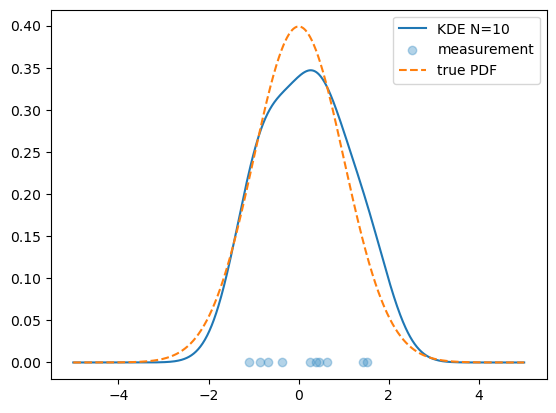

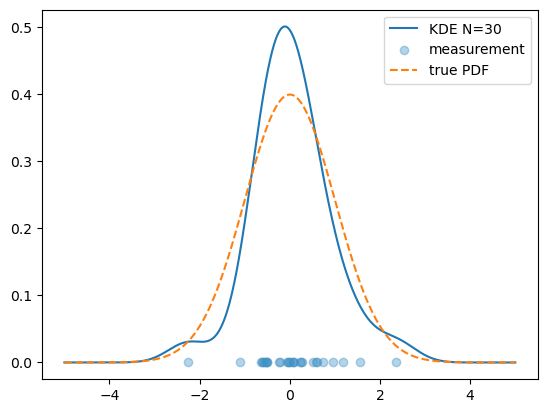

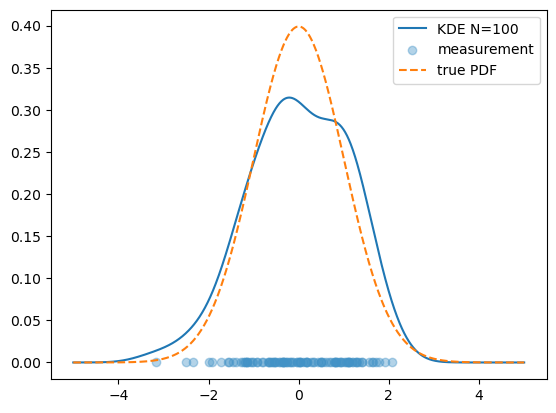

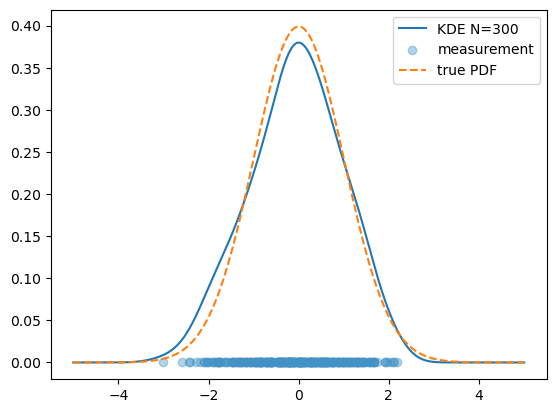

<Figure size 640x480 with 0 Axes>

In [251]:
N = np.array([10, 30, 100, 300])
x_range = np.linspace(-5, 5, 1001)
for i in range(len(N)):
    data = np.random.normal(0., 1., N[i])
    p = KDE(data, x_range)
    plt.plot(x_range, p, label=f"KDE N={N[i]}")
    plt.scatter(data, np.zeros(len(data)), color="#4292c6", alpha=0.4, label="measurement")
    plt.plot(x_range, 1/np.sqrt(2*np.pi)*np.exp(-0.5*x_range**2), label="true PDF", linestyle="--")
    # plt.title(f"KDE N={N[i]}")
    plt.legend()
    plt.show()
    plt.clf()
    



### Question B)

In [252]:
def KDE_2D(data, x_range, y_range):
    N = data.shape[0]
    std = np.std(data, axis=0)
    bandwidth = std/(N)**(1/6)
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    p = 0
    for i in range(N):
        diff_x = x_mesh - data[i, 0]
        diff_y = y_mesh - data[i, 1]
        p += np.exp(-0.5*(diff_x/bandwidth[0])**2)*np.exp(-0.5*(diff_y/bandwidth[1])**2)
        
    p = p/np.trapz(np.trapz(p, x_range, axis=0), y_range,axis=0)
    return p  


/scratch-local/slurm-job-tmp-215162/ipykernel_1467/3127098014.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x_mesh, y_mesh, p, label=f"KDE N={N[i]}", cmap="coolwarm")


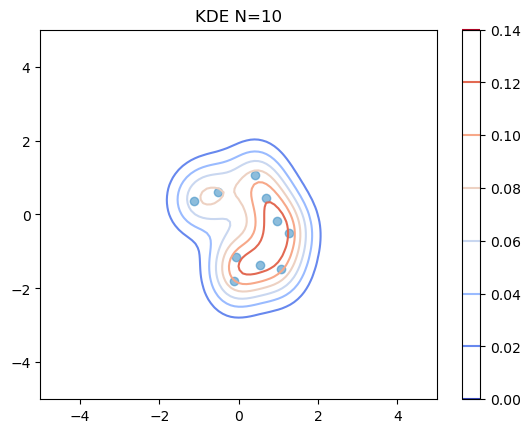

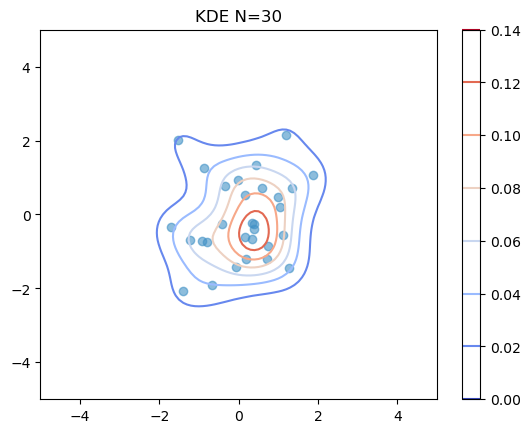

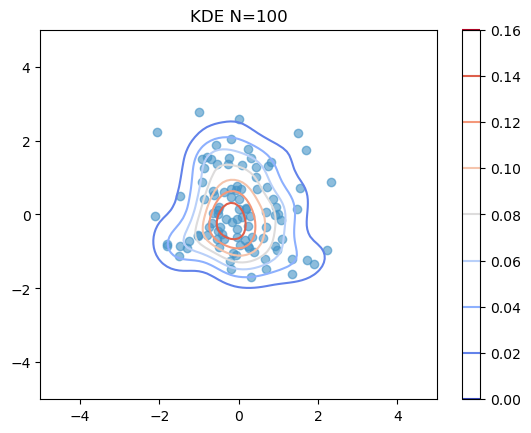

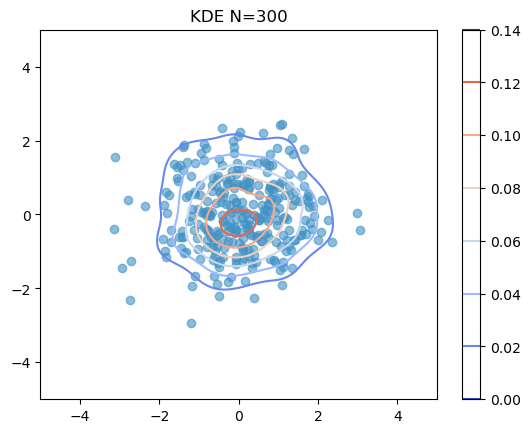

<Figure size 640x480 with 0 Axes>

In [253]:
N = np.array([10, 30, 100, 300])
x_range = np.linspace(-5, 5, 101)
y_range = x_range 
x_mesh, y_mesh = np.meshgrid(x_range, y_range)

for i in range(len(N)):
    data = np.random.normal(0., 1., size=(N[i], 2))
    p = KDE_2D(data, x_range, y_range)
    plt.contour(x_mesh, y_mesh, p, label=f"KDE N={N[i]}", cmap="coolwarm")
    plt.colorbar()
    plt.scatter(data[:, 0], data[:, 1], color="#4292c6", alpha=0.6, label="measurement")
    # plt.plot(x_range, 1/np.sqrt(2*np.pi)*np.exp(-0.5*x_range**2), label="true PDF", linestyle="--")
    plt.title(f"KDE N={N[i]}")
    # plt.legend()
    plt.show()
    plt.clf()
    





### Question C)

In [254]:
def blackbox_simulator(alpha, N):
    return np.random.standard_cauchy(size = N)+alpha**2

In [255]:
# alpha = np.random.uniform(0., 2., 4)
# x_range = np.linspace(-100, 100, 1001)
# for i in range(len(alpha)):
#     data = blackbox_simulator(alpha[i], 30000)
#     p = KDE(data, x_range)
#     # x_max = 
#     x_max_idx = np.where(p==np.max(p))[0][0]
#     plt.plot(x_range, p, label=rf"$\alpha={alpha[i]:.2f}$")
#     plt.axvline(x_range[x_max_idx], linestyle="--", color="orange")
#     plt.legend()
#     # plt.scatter(x_range, np.zeros_like(x_range))
#     plt.show()
#     plt.clf()

In [256]:
def KDE_2D_GPU(data, x_range, y_range):
    data = torch.tensor(data).to(device)
    x_range = torch.tensor(x_range).to(device)
    y_range = torch.tensor(y_range).to(device)
    N = data.shape[0]
    std = torch.std(data, dim=0)
    bandwidth = std/(N)**(1/6)
    x_mesh, y_mesh = torch.meshgrid(x_range, y_range)
    x_mesh = x_mesh.T
    y_mesh = y_mesh.T
    p = 0
    for i in range(N):
        diff_x = x_mesh - data[i, 0]
        diff_y = y_mesh - data[i, 1]
        p += torch.exp(-0.5*(diff_x/bandwidth[0])**2)*torch.exp(-0.5*(diff_y/bandwidth[1])**2)
    p = p.detach().cpu().numpy() 
    p = p/np.trapz(np.trapz(p, x_range.detach().cpu().numpy(), axis=0), y_range.detach().cpu().numpy(), axis=0)
    return p

In [257]:
N = 30000
alpha_range = np.linspace(-0.5, 2.5, 101)
d_range = np.linspace(-50, 50, 101)
data_list = np.zeros(shape=(N, 2))

for i in range(N):
    np.random.seed(i)
    alpha = np.random.uniform(0., 2., 1)
    np.random.seed(30000000+i)
    d = blackbox_simulator(alpha, 1)
    data = np.array([alpha, d]).reshape(-1, 2)
    data_list[i, :] = data




In [258]:
p  = KDE_2D(data_list, alpha_range, d_range)



In [259]:
p_GPU = KDE_2D_GPU(data_list, alpha_range, d_range)

Text(0, 0.5, '$d$')

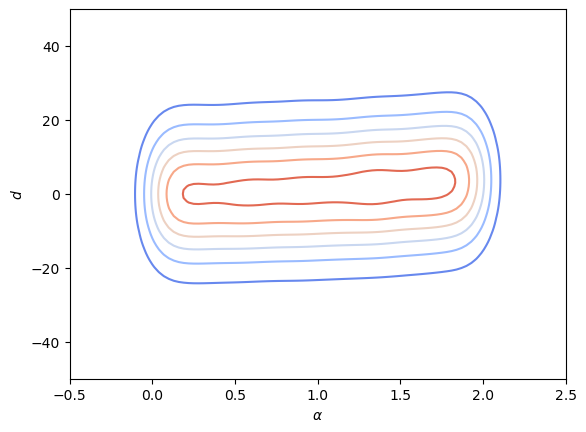

In [260]:
plt.contour(alpha_range, d_range, p, cmap="coolwarm")
plt.xlabel(r"$\alpha$")
plt.ylabel("$d$")

Text(0, 0.5, '$d$')

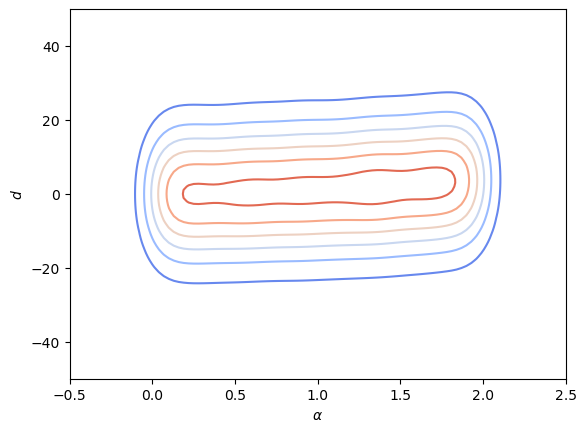

In [261]:
plt.contour(alpha_range, d_range, p_GPU, cmap="coolwarm")
plt.xlabel(r"$\alpha$")
plt.ylabel("$d$")

In [262]:
# plt.imshow(p, cmap="coolwarm")
# print(x_mesh)

In [263]:
np.random.seed(114514)
d_hat = blackbox_simulator(1, 1)

d_hat_pos_idx = np.where(np.abs(d_hat - d_range)==np.min(np.abs(d_hat - d_range)))[0][0]


print(d_hat_pos_idx)

52


Text(0.5, 0, '$\\alpha$')

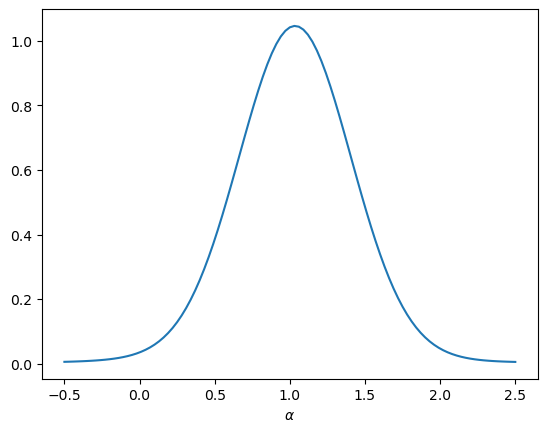

In [264]:
p_alpha = p[:, d_hat_pos_idx]
plt.plot(alpha_range, p_alpha/np.trapz(p_alpha, alpha_range))
plt.xlabel(r"$\alpha$")

### Question d)

In [265]:
alpha_range = np.linspace(-5, 5, 1001)

# np.random.seed(114514)
# d_hat = blackbox_simulator(1, 1)
d_hat = 1.0
print(d_hat)

posterior_d = np.zeros_like(alpha_range)

for i in range(len(alpha_range)):
    result = 1/(np.pi*(1+(d_hat-alpha_range[i]**2)**2))
    posterior_d[i] = result
    

posterior_d = posterior_d/np.trapz(posterior_d, alpha_range)




1.0


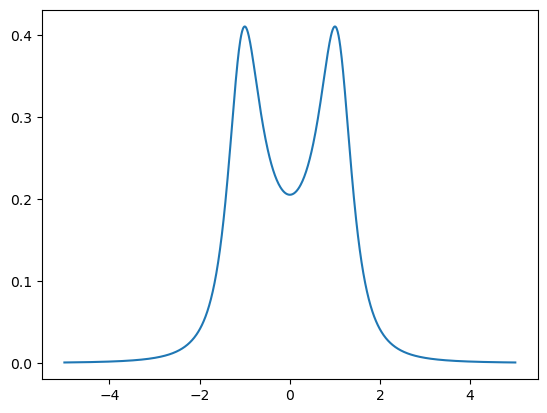

In [266]:
plt.plot(alpha_range, posterior_d)
# plt.xlim(-2, 2)
